# Notebook \#2 - Fourier Neural Operator

In this jupyter notebook, we are going to cover how Fourier Neural Operator can be used to solve a control problem that has differential equation as one of the constraint. The structure of the notebooks is as follows:
- Preinstall and import all needed libraries
- Generate a training dataset 
- Train operator
- Solve optimization problem
- Compare with analytical solution

In [ ]:
#Make sure that you have installed all dependencies
#pip install -r requirements.txt

from torch.utils.data import DataLoader
import numpy as np

# utils folder contains all the functions to load the data, train the model and plot the results
# models folder contains the model architectures
from utils.data import MultiFunctionDatasetODE, custom_collate_ODE_fn_fno 
from utils.scripts import *
from models.fno import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate dataset

Suppose we have a parametric differential equation. This can be any arbitrary ode/pde, but for the sake of simplicity, let it be:
$$\frac{dx}{dt} - x(t) + u(t) = 0$$
where $u(t)$ is some arbitrary function or "parameter". And $x(t)$ is such function that ode is solved correctly.

We would like to train a model that can learn a mapping $u(t)\rightarrow x(t)$

At first we need to generate a dataset. This can be done using `MultiFunctionDatasetODE` function. It would generate 1000000 functions of different function families (`'grf', 'linear', 'sine', 'polynomial', 'constant'`). 

The time range would be $[0,1]$. For the Fourier Neural Operator, time should be discretized. In our case we set `m=200`, implying "200 sensors" or measurments. 

We split this into batches of size `1024`

In [3]:
n_functions = 1000000
end_time = 1.0
m = 200
batch_size = 1024
t_grid = torch.linspace(0, end_time, m).unsqueeze(0).repeat(batch_size, 1).unsqueeze(-1)

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial', 'constant'],
    end_time=end_time,
    num_domain=m,
    num_initial=20,
    grf_lb=0.02,
    grf_ub=0.5
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn_fno, shuffle=True)

# Fourier Neural Operator

You can find source code of the FNO in the `models/fno.py` file.

## Theory

The Fourier Neural Operator (FNO) learns mappings between function spaces by parameterizing convolution in the frequency domain. Rather than learning a dense spatial kernel, each fourier layer performs:

- Forward FFT of the input field
- Spectral filtering via learnable complex weights on a limited set of low-frequency modes
- Inverse FFT back to the spatial domain
- This yields an $\mathcal{O}(N\log N)$ layer that captures global interactions efficiently.

### `SpectralConv1d`

Role: Implements one-dimensional spectral convolution over input channels.

Key parameters:
- `in_channels` / out_channels: feature dimensions before/after convolution
- `modes1`: number of lowest Fourier modes to keep
- `weights1`: learnable complex weights of shape `(in_channels, out_channels, modes1)`

### `SimpleBlock1d`

Role: Builds a single FNO “layer block” with four spectral convolutions and pointwise shortcuts.

Key components:
- Input lift: a linear layer that maps 2-dimensional per‐point inputs (e.g. `[u, t]`) into a higher‐dimensional feature space (width)
- Spectral branches: four instances of SpectralConv1d, each paired with a 1×1 convolution for local (pointwise) mixing
- Activations: `GELU` after each combined spectral + pointwise output, except the final
- Projection: two fully connected layers that map from width back down to a scalar output per point


### `FNO1d`

Role: A thin wrapper exposing a single SimpleBlock1d as the overall model.

Inputs:
- `u` (batch of spatial fields), shape `(B, N)`
- `t` (auxiliary feature, e.g. time coordinate), shape `(B, N, 1)`

Parameters:
- `modes`: controls how many Fourier modes are retained in each spectral convolution
- `width`: hidden feature dimension inside the block

Forward pass:
- Concatenate u and t along the last axis → per‐point 2D vector
- Feed into the single SimpleBlock1d
- Output a scalar field `(B, N, 1)`


## Practicalities

***Choice of modes:***
Balances resolution (higher modes capture finer variations) against stability and overfitting.

***Choice of width:***
Affects model capacity; larger widths can model more complex operators but increase compute.

***Computational cost:***
Each spectral conv uses FFT/​iFFT (cost $\sim N\log N$) plus a small complex‐weight multiplication on modes channels.

## Train model

The workflow is simple. To create a model, you need to call `FNO1d()`. It has only input parameters `modes` and `width`.

In [4]:
model = FNO1d(modes=16, width=64).to(device)

Then you need to define `optimizer` and `scheduler` with any preferable settings

In [5]:
step_size = 100
gamma = 0.9
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

To train FNO, you need to use your custom train function that depends on your problem. In our case, we have `train_fno()` from `utils.scripts.py`

Notice that `train_fno()` uses function `compute_loss()`, which is defined in the same file. Basically, this functions tells FNO that we are trying to learn:
$$\frac{dx}{dt} + x(t) - u(t) = 0$$
$$x(0) = 1$$
$$t\in[0,1]$$

Thus, in this problem we have 2 "sources of loss": initial and physics loss. You can define variable `w` to set different weights to either of losses. 

After every `epoch`, model is saved. Make sure to define a folder where you want to store models. By default, it is `trained_models/fno`

In [8]:
epochs = 1
trained_model = train_fno(model, dataloader, optimizer, scheduler, epochs, t_grid, logging=False)

Epoch [1/1], Loss: 0.006708, Time: 173.834647 s


## Load pre-trained model

Or you can just load pre-trained model as usually

In [2]:
trained_model = FNO1d(modes=16, width=64)
trained_model.to(device)
trained_model.load_state_dict(torch.load('trained_models/fno/width-[64]-modes[16]/model_epoch10_20250421-212647_loss0.0013.pth'))
trained_model.eval()  #

FNO1d(
  (conv1): SimpleBlock1d(
    (fc0): Linear(in_features=2, out_features=64, bias=True)
    (conv0): SpectralConv1d()
    (conv1): SpectralConv1d()
    (conv2): SpectralConv1d()
    (conv3): SpectralConv1d()
    (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Solve Control Problem

Once we succesefully trained Fourier Neural Operator. We can solve next control problem:
$$\text{min}_u \ \int_{0}^{1} (x^2 + u^2)dt$$
$$\text{s.t.} \ \frac{dx}{dt} = x - u$$
$$ x(0) = 1$$

***Note:*** everything related to implementation of objective function was explained in a notebook related to Deep-O-Net in `playground.ipynb`

Idea is simple, we have a model that maps $u$ to $x$. We can start from some random function $u$, find $x$ that solves ode and initial condition using NN. Calculate objective function:
$$\text{min}_u \ \int_{0}^{1} (x^2 + u^2)dt$$
Update $u$ and repeat process again. 

The whole process relies on the fact that FNO indeed can provide solution $x$.

`optimize_neural_operator()` solves this problem given pretrained FNO model. Notice that it has as input parameter `objective_function()` 

In [3]:
m = 200 
end_time = 1
epochs = 1500
learning_rate = 0.001

u_opt, x_opt, t_opt = optimize_neural_operator(trained_model, objective_function, m, end_time, epochs, learning_rate, model_name="fno")

Epoch [100/1500], Loss: 0.4376, time: 01:11:45.237344
Epoch [200/1500], Loss: 0.4142, time: 01:11:45.622864
Epoch [300/1500], Loss: 0.4009, time: 01:11:46.006740
Epoch [400/1500], Loss: 0.3933, time: 01:11:46.433052
Epoch [500/1500], Loss: 0.3891, time: 01:11:46.815849
Epoch [600/1500], Loss: 0.3867, time: 01:11:47.200269
Epoch [700/1500], Loss: 0.3854, time: 01:11:47.578745
Epoch [800/1500], Loss: 0.3847, time: 01:11:47.957770
Epoch [900/1500], Loss: 0.3844, time: 01:11:48.338174
Epoch [1000/1500], Loss: 0.3842, time: 01:11:48.718355
Epoch [1100/1500], Loss: 0.3841, time: 01:11:49.100082
Epoch [1200/1500], Loss: 0.3840, time: 01:11:49.481113
Epoch [1300/1500], Loss: 0.3840, time: 01:11:49.860621
Epoch [1400/1500], Loss: 0.3840, time: 01:11:50.238510
Epoch [1500/1500], Loss: 0.3840, time: 01:11:50.617301


## Comparison with analytical solution

From the paper "Convergence of the forward-backward sweep method in optimal control" by Michael McAsey et al, we know that analytical solution for this problem is:

$$x(t) = \frac{\sqrt{2}\cosh(\sqrt{2}(t-1)) - \sinh(\sqrt{2}(t-1))}{\sqrt{2}\cosh(\sqrt{2})+\sinh{\sqrt{2}}}$$
$$u(t) = \frac{\sinh(\sqrt{2}(t-1))}{\sqrt{2}\cosh(\sqrt{2})+\sinh{\sqrt{2}}}$$

We can use these functions to confirm that we indeed found an optimal solution.

In [4]:
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Generate time grid for plotting
t_plot = np.linspace(0, end_time, m)  # m points from 0 to end_time

# Evaluate analytical solutions on the grid
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

# Extract model-found solutions and move to NumPy for comparison
x_found = x_opt.cpu().detach().numpy().flatten()
u_found = u_opt.cpu().detach().numpy().flatten()

# Prepare a tensor of the analytical u values for potential model input
u_tensor = torch.from_numpy(analytical_u_vals).float().unsqueeze(0).to(device)  

As you can see from the plot below, using FNO we managed to find solution close to analytical one. To train FNO, we did `10 epochs`, which approximatelly took 30 minutes. We had next input parameters `width=64`, `modes=16`

But, we could even use model trained on `3 epochs`

For the true $u(t)$, FNO outputs perfect $x(t)$ as analytical one. For some reason, the found solution for at $t=0$ has an "abrupt jump". 

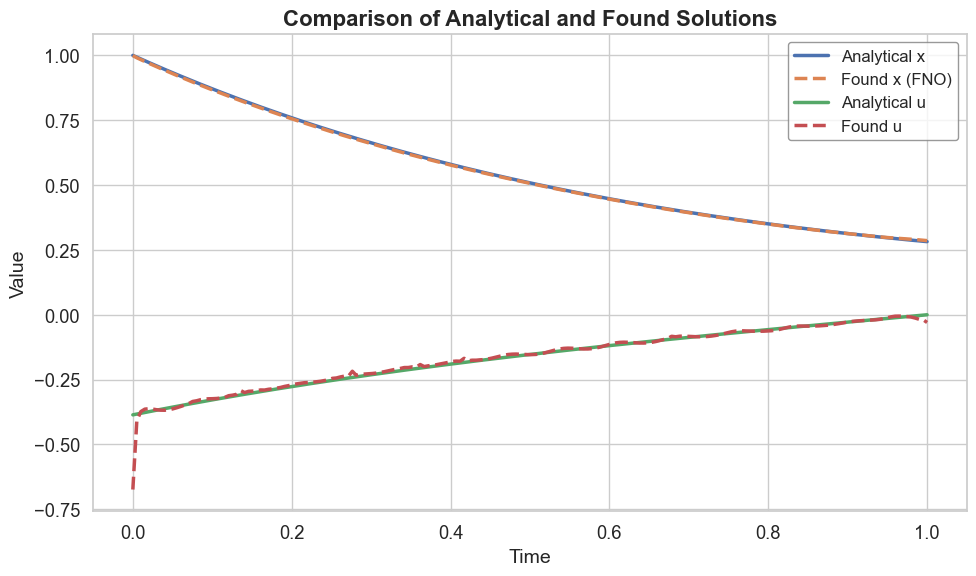

In [6]:
plot_analytical_and_found_solutions(t_plot, analytical_x_vals, x_found, analytical_u_vals, u_found)